# Climate Hack.AI 2022

Thank you for participanting in Climate Hack.AI 2022!

Your hard work in helping to advance the state of the art in HRV satellite imagery nowcasting could be incredibly impactful in the broader fight against climate change. Within the UK electricty grid alone, your model could contribute to a reduction in carbon emissions of up to 100 kilotonnes a year.

Happy model training!

## Your Challenge

TODO: explain the challenge

## Prerequisites

Before you begin, please ensure that you have the following packages installed.

* `xarray` for representing n-dimensional labelled arrays
* `zarr` for loading the Zarr dataset
* `gcsfs` for loading from Google Cloud Storage:  used implicitly by xarray)
* `dask` used under the hood by xarray to enable parallel processing of datasets too large to fit into RAM
* `torch` (PyTorch) for training a model
* `matplotlib` for plotting

If you are familar with `conda`, you may want to run the following commands:

```bash
$ conda create --name climatehack python=3.9 numpy matplotlib zarr xarray ipykernel gcsfs fsspec dask cartopy
$ conda activate climatehack
$ conda install pytorch torchvision torchaudio cpuonly -c pytorch
$ conda install -c pvlib pvlib
```

## Importing modules

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
from torch.utils.data import DataLoader

from dataset import ClimateHackDataset
from submission.model import Model

plt.rcParams["figure.figsize"] = (20, 12)

## Loading the dataset

The 104GB HRV ("high resolution visible") satellite imagery dataset may be loaded directly from Google Cloud Public Datasets using `xarray`, `zarr`, `gcsfs` and `dask`.

### Loading the dataset from the cloud

In [2]:
# TODO: Update this path to the path on Google Cloud Public Datasets when the dataset is published on Public Datasets.
SATELLITE_ZARR_PATH = "gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr" 

dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr", 
    chunks="auto",  # Load the data as a Dask array
)

print(dataset)

<xarray.Dataset>
Dimensions:  (time: 26148, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01T09:00:00 ... 2020-09-01T16:00:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(1, 891, 1843), meta=np.ndarray>


### Loading a local copy of the dataset

If you would rather download a subset or the entirety of the dataset to use locally in training, create, edit and run the following code block below:

```python
# Instead of selecting the entire 104GB dataset as below, you may want to use a significantly narrower date range!
dataset.sel(time=slice("2020-01-01 00:05", "2021-11-07 15:50")).to_zarr("training.zarr")
```

Then, load the dataset using the following line of code instead.

```python
dataset = xr.open_zarr("training.zarr", consolidated=True)
```

## Visualising the data

You may be curious what these 1841x891 "high resolution visible" satellite images actually look like! 

Here is an example:

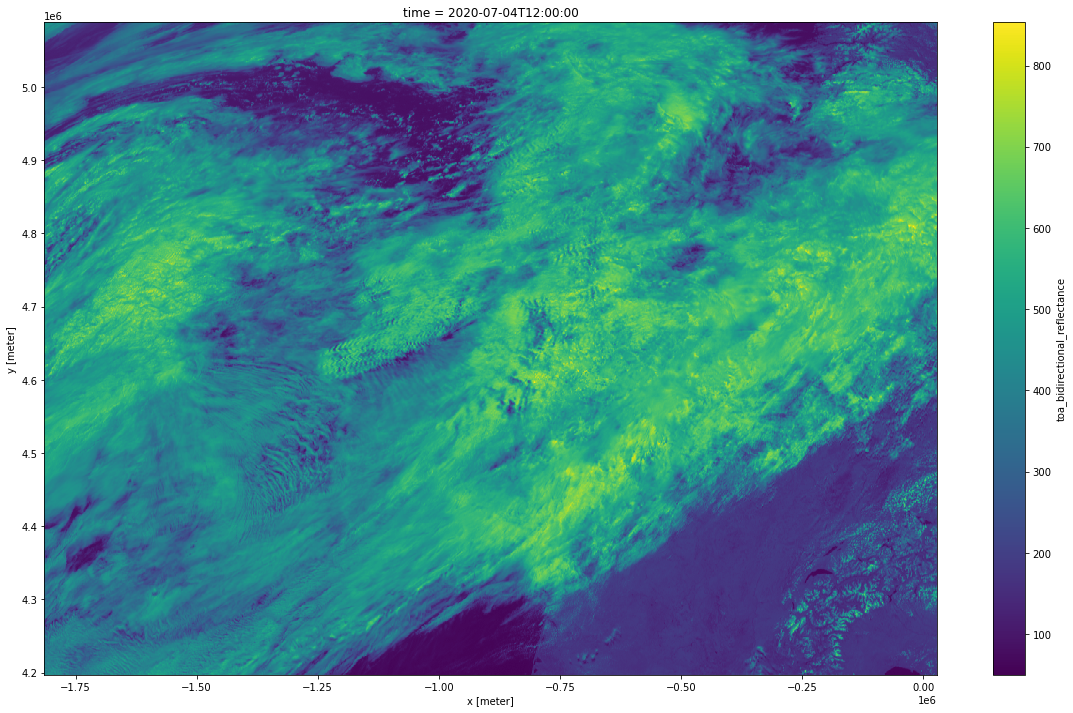

In [3]:
dataset["data"].sel(time="2020-06-01 12:00").plot()

As part of your challenge, you are given twelve 128x128 images taken five minutes apart corresponding to some region inside the 1841x891 image above, e.g.

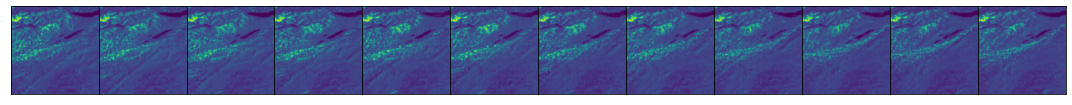

In [4]:
fig, ax = plt.subplots(1, 12, figsize=(15,3))

for i, d in enumerate(["2020-07-04 12:00", "2020-07-04 12:05", "2020-07-04 12:10", "2020-07-04 12:15", "2020-07-04 12:20", "2020-07-04 12:25", "2020-07-04 12:30", "2020-07-04 12:35", "2020-07-04 12:40", "2020-07-04 12:45", "2020-07-04 12:50", "2020-07-04 12:55"]):
    ax[i].imshow(dataset["data"].sel(time=d).isel(x=slice(128, 256), y=slice(128, 256)).to_numpy(), cmap='viridis')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

From these, your aim is to predict the next twelve images taken five minutes apart for the centre 64x64 region of the 128x128 area. 

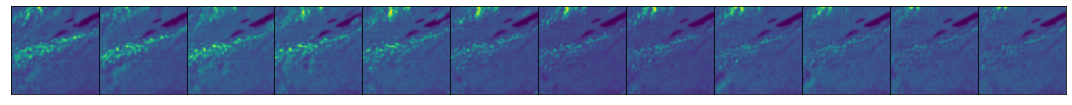

In [5]:
fig, ax = plt.subplots(1, 12, figsize=(15,3))

for i, d in enumerate(["2020-07-04 13:00", "2020-07-04 13:05", "2020-07-04 13:10", "2020-07-04 13:15", "2020-07-04 13:20", "2020-07-04 13:25", "2020-07-04 13:30", "2020-07-04 13:35", "2020-07-04 13:40", "2020-07-04 13:45", "2020-07-04 13:50", "2020-07-04 13:55"]):
    ax[i].imshow(dataset["data"].sel(time=d).isel(x=slice(160, 224), y=slice(160, 224)).to_numpy(), cmap='viridis')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

## Creating a model

### Defining constants

In [6]:
BATCH_SIZE = 60
EPOCHS = 5


### Instantiating the DataLoader

Since the dataset is so large, we have provided a `ClimateHackDataset` class in `dataset.py` that selects a sliding window of twelve 128x128 images (taken five minutes apart, corresponding to an hour of data) for randomly sampled areas roughly over the mainland UK to use in training.

In [7]:
# Increase samples_per_slice if you want to sample multiple areas in the same sliding window.
# To only train on a subset of the dataset, either select what you want and pass it into ClimateHackDataset,
# or set day_limit > 0 to the number of days from the start to read.

ch_dataset = ClimateHackDataset(dataset["data"], samples_per_slice=1, day_limit=2)
ch_dataloader = DataLoader(ch_dataset, batch_size=BATCH_SIZE)

### Instantiating the model

Any models you define need to be in the `submission` folder so that they can be evaluated on DOXA. By default, they are defined in `submission/model.py`, which is where this PyTorch model is defined.

There are some huge improvements you can make to this basic model, so feel free to use this as a starting point and customise `submission/model.py` to your liking!

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model().to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss() # TODO: use MS SSIM loss

### Training the model

In [9]:
losses = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")
    running_loss = 0
    i = 0
    for batch_features, batch_targets in ch_dataloader:
        print(f"Epoch {epoch + 1} -- batch {i}")
        batch_features = batch_features.view(-1, 12 * 128 * 128).to(device)
        batch_targets = batch_targets.view(-1, 12 * 64 * 64).to(device)
        
        batch_loss = criterion(model(batch_features), batch_targets)

        optimiser.zero_grad()
        batch_loss.backward()        
        optimiser.step()

        running_loss += batch_loss.item() * batch_features.size(0)
        i += 1
    
    losses.append(running_loss / (BATCH_SIZE * i))
    print(f"Loss for epoch {epoch + 1}/{EPOCHS}: {losses[-1]}")

Epoch 0
Epoch 0 -- batch 0
Epoch 0 -- batch 1
Loss for epoch 1/5: 46417.7666015625
Epoch 1
Epoch 1 -- batch 0
Epoch 1 -- batch 1
Loss for epoch 2/5: 45199.5
Epoch 2
Epoch 2 -- batch 0
Epoch 2 -- batch 1
Loss for epoch 3/5: 49973.6435546875
Epoch 3
Epoch 3 -- batch 0
Epoch 3 -- batch 1
Loss for epoch 4/5: 47444.7021484375
Epoch 4
Epoch 4 -- batch 0
Epoch 4 -- batch 1
Loss for epoch 5/5: 46708.775390625


### Saving the model

Having trained the model, it can now be saved in the `submission` folder so that it may be evaluated on [DOXA](https://climatehack.ai/compete).

In [10]:
torch.save(model.state_dict(), 'submission/model.pt')

## Submitting your model to DOXA

Well done -- you made it to the end!

You are now ready to submit your model to DOXA!

If you are not already logged in, run the following command:

```bash
$ python doxa_cli.py user login
```

Finally, to submit your model, upload the entire `submission` folder into which your model was saved using the following command:

```bash
$ python doxa_cli.py agent upload climatehack ./submission
```